## Manual challenge

A big group of Sea Turtles is visiting our shores, bringing with them an opportunity to acquire some top grade `FLIPPERS`. You only have two chances to offer a good price. Each one of the Sea Turtles will accept the lowest bid that is over their reserve price. 

The distribution of reserve prices is uniform between 160–200 and 250–320, but none of the Sea Turtles will trade between 200 and 250 due to some ancient superstition.

For your second bid, they also take into account the average of the second bids by other traders in the archipelago. They’ll trade with you when your offer is above the average of all second bids. But if you end up under the average, the probability of a deal decreases rapidly. 

To simulate this probability, the PNL obtained from trading with a fish for which your second bid is under the average of all second bids will be scaled by a factor *p*:

$$
p = (\frac{320 – \text{average bid}}{320 – \text{your bid}})^3
$$

You know there’s a constant desire for Flippers on the archipelago. So, at the end of the round, you’ll be able to sell them for 320 SeaShells ****a piece.

Think hard about how you want to set your two bids, place your feet firmly in the sand and brace yourself, because this could get messy.

The best bid is 200.0


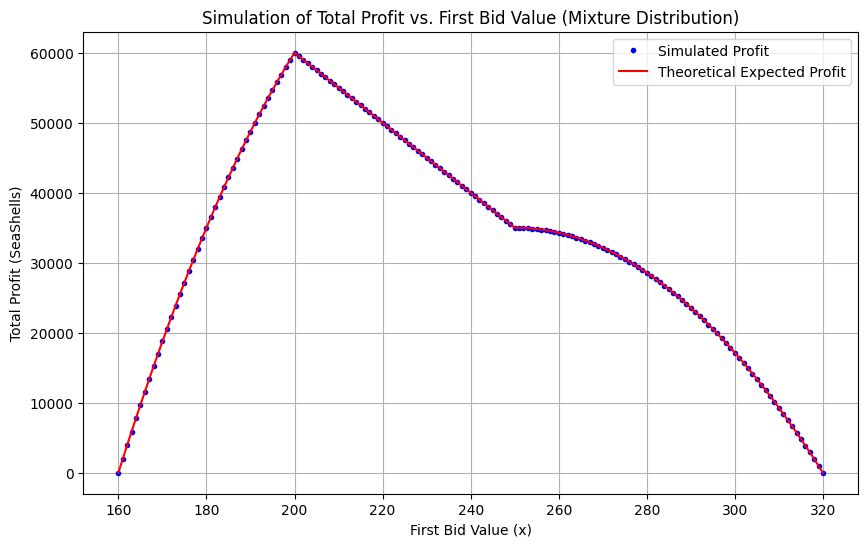

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_first_bid_mixture(x, n, num_simulations=10000):
    """
    Simulate total profit from placing a single bid at value x,
    when the turtle population is a 50/50 mixture of:
      - low reserve turtles: reserve ~ Uniform(160, 200)
      - high reserve turtles: reserve ~ Uniform(250, 320)
      
    Parameters:
      x               : The bid amount.
      n               : Total number of turtles.
      num_simulations : Number of simulation runs.
      
    Returns:
      Average total profit over the simulation runs.
    """
    # Assume half the turtles are low reserve and half are high reserve.
    n_low = n // 2
    n_high = n - n_low  # To handle odd n.
    
    profits = []
    for _ in range(num_simulations):
        # Generate reserves for each sub-population.
        reserves_low = np.random.uniform(160, 200, size=n_low)
        reserves_high = np.random.uniform(250, 320, size=n_high)
        reserves = np.concatenate([reserves_low, reserves_high])
        
        # A turtle accepts if its reserve is strictly less than the bid x.
        accepted = np.sum(reserves < x)
        profit = accepted * (320 - x)
        profits.append(profit)
    
    return np.mean(profits)

# Set simulation parameters.
n = 1000  # Total number of turtles.
num_simulations = 10000

# Define a range of bid values x.
# We'll explore from 160 to 320.
x_values = np.linspace(160, 320, 161)  # 161 points from 160 to 320.

# Run simulations for each bid value.
simulated_profits = np.array([simulate_first_bid_mixture(x, n, num_simulations) for x in x_values])

best_bid = x_values[np.argmax(simulated_profits)]
print(f"The best bid is {best_bid}")

# -----------------------------------------------------------------
# Compute the theoretical expected profit.
# For the low reserve group (Uniform[160,200]):
#   - For x in (160,200): fraction accepted = (x-160)/40.
#   - For x >= 200: all low reserve turtles are accepted.
#
# For the high reserve group (Uniform[250,320]):
#   - For x <= 250: none are accepted.
#   - For x in (250,320): fraction accepted = (x-250)/70.
#
# Profit per accepted turtle is (320 - x).
# Total Expected Profit = (accepted_low + accepted_high) * (320 - x)
# -----------------------------------------------------------------
n_total = n
n_low = n_total / 2
n_high = n_total / 2

theoretical_profit = []
for x in x_values:
    # For the low reserve group:
    if x <= 160:
        accepted_low = 0
    elif x < 200:
        accepted_low = n_low * ((x - 160) / 40)
    else:
        accepted_low = n_low

    # For the high reserve group:
    if x <= 250:
        accepted_high = 0
    elif x < 320:
        accepted_high = n_high * ((x - 250) / 70)
    else:
        accepted_high = n_high  # x >= 320; all high reserve turtles are accepted.

    expected = (accepted_low + accepted_high) * (320 - x)
    theoretical_profit.append(expected)

theoretical_profit = np.array(theoretical_profit)

# Plot the simulation results alongside the theoretical expected profit.
plt.figure(figsize=(10, 6))
plt.plot(x_values, simulated_profits, 'bo', markersize=3, label="Simulated Profit")
plt.plot(x_values, theoretical_profit, 'r-', label="Theoretical Expected Profit")
plt.xlabel("First Bid Value (x)")
plt.ylabel("Total Profit (SeaShells)")
plt.title("Simulation of Total Profit vs. First Bid Value (Mixture Distribution)")
plt.legend()
plt.grid(True)
plt.show()


Assuming we set our lowest bid to 200, to capture the group of turtles from 160-200
our second bid must sit between 250 and 320 to capture the second group.

its \lessthan x tho so the turtle with reserve == 200 is not captured by a bid of 200

assume average bid is x
if our bid b, where b > x, we always trade at (320 - b) * num trades
but if b < x, (320 - b) * num trades * ((320 - x) / (320 - b))^3 = (320 - x)^3 * num trades / (320 - b)^2

find the EV of trading at all numbers from 250-320

The best second bid is 288.00 SeaShells.


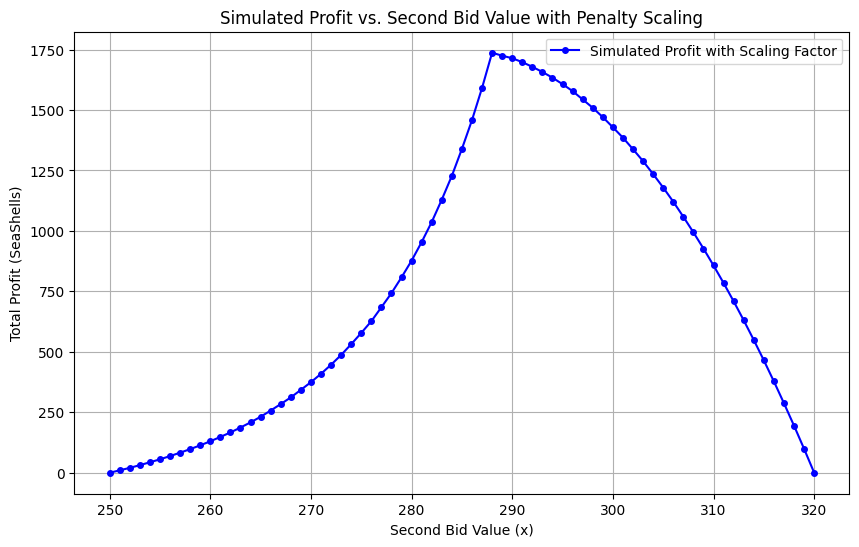

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_second_bid_profit(x, n_high, num_simulations=10000, opp_average_bid=288):
    """
    Simulate profit earned from trading with high-reserve turtles when placing a second bid at x,
    taking into account the scaling factor p:
    
       p = ((320 - opp_average_bid) / (320 - x))^3   if x < opp_average_bid,
           1                                        otherwise.
    
    Each turtle with a reserve (uniform on [250,320]) that is strictly below x accepts,
    and you earn a base profit of (320 - x) SeaShells per accepted trade.
    
    Parameters:
      x               : Your second bid (between 250 and 320).
      n_high          : Number of turtles in the high-reserve group.
      num_simulations : Number of simulation runs.
      opp_average_bid : The assumed average second bid from your competitors.
      
    Returns:
      The average profit over all simulation runs.
    """
    profits = []
    for _ in range(num_simulations):
        # Simulate high-reserve turtle reserves.
        reserves = np.random.uniform(250, 320, size=n_high)
        accepted = np.sum(reserves < x)
        base_profit = accepted * (320 - x)
        
        # Determine scaling factor:
        if x < opp_average_bid:
            p = ((320 - opp_average_bid) / (320 - x)) ** 3
        else:
            p = 1.0
        
        profits.append(base_profit * p)
    
    return np.mean(profits)

# Simulation parameters.
# n_total was 1000 before (with half high-reserve), so here n_high is 500.
n_high = 100    
num_simulations = 10000
# Define second bid x values from 250 to 320.
x_values = np.linspace(250, 320, 71)  # 71 evenly spaced values

# Run simulation for each second bid x.
simulated_profits = np.array([simulate_second_bid_profit(x, n_high, num_simulations) for x in x_values])

# Identify the best second bid (the x value that maximizes simulated profit).
best_bid = x_values[np.argmax(simulated_profits)]
print(f"The best second bid is {best_bid:.2f} SeaShells.")

# Plot simulation results.
plt.figure(figsize=(10, 6))
plt.plot(x_values, simulated_profits, 'bo-', markersize=4, label="Simulated Profit with Scaling Factor")
plt.xlabel("Second Bid Value (x)")
plt.ylabel("Total Profit (SeaShells)")
plt.title("Simulated Profit vs. Second Bid Value with Penalty Scaling")
plt.legend()
plt.grid(True)
plt.show()


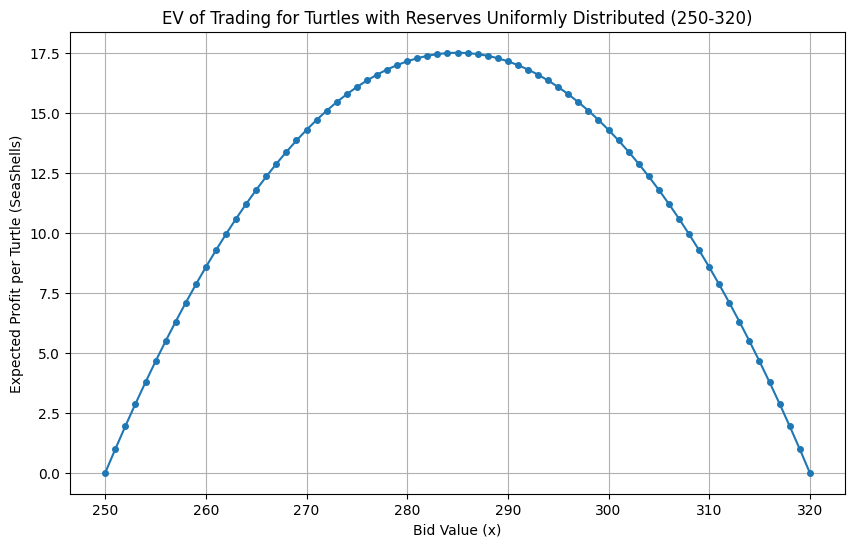

The optimal bid is 285.00 SeaShells with an expected profit of 17.50 SeaShells per turtle.


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define bid values from 250 to 320.
bid_values = np.linspace(250, 320, 71)  # 71 points; adjust density as needed.

# Calculate the expected profit (EV) for each bid x.
EV = (bid_values - 250) / 70 * (320 - bid_values)

# Plot the Expected Value (EV) vs. bid values.
plt.figure(figsize=(10, 6))
plt.plot(bid_values, EV, marker='o', linestyle='-', markersize=4)
plt.xlabel("Bid Value (x)")
plt.ylabel("Expected Profit per Turtle (SeaShells)")
plt.title("EV of Trading for Turtles with Reserves Uniformly Distributed (250-320)")
plt.grid(True)
plt.show()

# Find the bid value that maximizes the EV.
optimal_index = np.argmax(EV)
best_bid = bid_values[optimal_index]
max_EV = EV[optimal_index]

print(f"The optimal bid is {best_bid:.2f} SeaShells with an expected profit of {max_EV:.2f} SeaShells per turtle.")


how does game theory interact with this here.

let p(x) be prob turtle accepts

p(x) = (x - 250) / 70
profit = 320 - x

E(x) = (320 - x)(x - 250)/7

diff and find maxima, x = 285 optimal soln

E(x, for x < x_{ave}) = ((x - 250)*(320 - x_{ave})^3) / (70 * (320 - x)^2)
E(x, for x > x_{ave}) = (320 - x)(x - 250)/7

optimal solution is to bid x_{ave} always.